## import need lib

In [2]:
import mxnet as mx
from mxnet import gluon, image, autograd, nd
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
from mxnet import metric
from mxnet.gluon import model_zoo

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time

import sys
sys.path.append("../")
from utils.utils import show_9_images, show_images, mkdir_if_not_exist

# dataset root dir
coins_root = "../dataset/"
sdl_root = coins_root + "sdl-coins/"
swiss_root = coins_root + "swiss-coins/"

data_shape = (3, 256, 256)
batch_size = 8
#mean = np.array([ 167.02477919,  157.20263027,  140.25492473])
#std = np.array([ 46.06696734,  47.12624331,  50.81295717])
rgb_mean = np.array([123, 117, 104])

ctx = mx.gpu(0)

## load evaluate data

In [3]:
def get_iterators(rec_prefix, data_shape, batch_size):
    class_names = ['1yuan', '0.5yuan']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_train.rec',
        path_imgidx=rec_prefix + '_train.idx',
        shuffle=True,
        mean=True,
        #std=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200,
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1,
        rand_mirror=True,
        aspect_ratio_range=(0.5, 2),
        pca_noise=0.01,
        #rand_gray=True
    )
    
    valid_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix+'_val.rec',
        shuffle=False,
        mean=True,
        #std=True
    )
    
    return train_iter, valid_iter, class_names, num_class

train_data, valid_data, class_names, num_class = get_iterators(sdl_root+"rec/sdl", data_shape, batch_size)

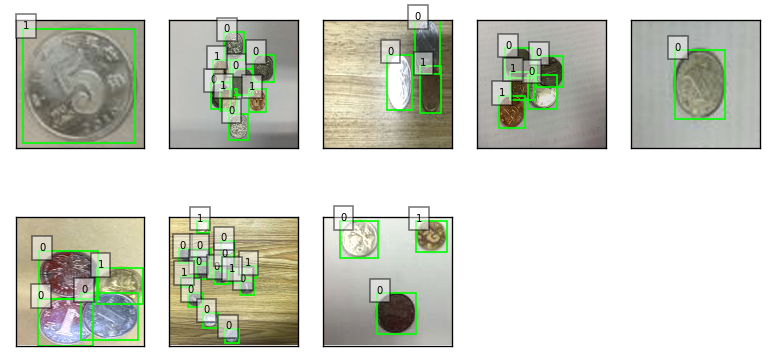

(8L, 14L, 5L)


In [4]:
"""
data plot
"""
mpl.rcParams['figure.dpi'] = 120

train_data.reset()
batch = train_data.next()
images = batch.data[0][:8]
labels = batch.label[0][:8]
show_images(images.asnumpy(), labels.asnumpy(), rgb_mean, show_text=True, fontsize=6)
#show_9_images(images.asnumpy(), labels, rgb_mean)
print labels.shape

## load net and evaluate

In [5]:
"""
model define
"""

def get_alexnet_conv(ctx):
    alexnet = model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(alexnet.features[:8]))
    return net

def get_vgg11bn_conv(ctx):
    vgg11bnnet = model_zoo.vision.vgg11_bn(pretrained=True, ctx=ctx)
    net = gluon.nn.HybridSequential()
    net.add(*(vgg11bnnet.features[:21]))
    return net

def get_mobilenet_1_conv(ctx):
    mobilenet = model_zoo.vision.mobilenet1_0()
    net = gluon.nn.HybridSequential()
    net.add(*mobilenet.features[:33])
    net.initialize(ctx=ctx)
    return net

def down_sample(num_filter):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

class SSD(nn.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, ctx, verbose=False, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = (len(sizes_list[0]) + len(ratios_list[0]) - 1)
        self.verbose = verbose
        
        with self.name_scope():
            # part 1
#             self.body = nn.HybridSequential()
#             for filters in [16, 32, 64]:
#                 self.body.add(down_sample(filters))
            # self.body = get_vgg11bn_conv(ctx)
            self.body = get_vgg11bn_conv(ctx)

            # part 2
            self.downsamples = nn.HybridSequential()
            for _ in range(3):
                self.downsamples.add(down_sample(128))

            # part 3
            self.class_predictors = nn.HybridSequential()
            self.box_predictors = nn.HybridSequential()
            for _ in range(5):
                self.class_predictors.add(class_predictor(num_class, num_anchors))
                self.box_predictors.add(box_predictor(num_anchors))
                
            self.downsamples.initialize(ctx=ctx)
            self.class_predictors.initialize(ctx=ctx)
            self.box_predictors.initialize(ctx=ctx)
            
    def hybrid_forward(self, F, x):
        x = self.body(x)
        cls_preds = []
        box_preds = []
        anchors = []
        for i in range(5):
            cls_preds.append((self.class_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            box_preds.append((self.box_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))

            if self.verbose:
                print "predict scale", i, x.shape, 'with', anchors[-1].shape, 'anchors'

            if i < 3:
                x = self.downsamples[i](x)
            elif i == 3:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        cls_preds = nd.concat(*cls_preds, dim=1).reshape((0, -1, num_class+1))
        box_preds = nd.concat(*box_preds, dim=1)
        anchors = nd.concat(*anchors, dim=1)
        return anchors, box_preds, cls_preds

sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5



In [6]:
net = SSD(2, sizes_list, ratios_list, ctx=ctx, verbose=False, prefix="ssd_")
net.load_params("../models/sdl_coin_vgg11bn.param", ctx=ctx)


In [160]:
import numpy as np
"""
attention: 
    1. use numpy, note type, v(int) = v(float), will cilp value
    2. use numpy, note copy, use copy when need deep copy to avoid shallow copy
"""
def IOU_1v1(box1, box2):
    """
    box=[xmin, ymin, xmax, ymax]
    """
    box = box1.copy()
    box[0] = max([box1[0], box2[0]])
    box[1] = max([box1[1], box2[1]])
    box[2] = min([box1[2], box2[2]])
    box[3] = min([box1[3], box2[3]])
    if box[0] >= box[2] or box[1] >= box[3]:
        return 0.
    area = (box[2] - box[0]) * (box[3] -  box[1])
    area1 = (box1[2] - box1[0]) * (box1[3] -  box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] -  box2[1])
    return float(area) / (area1 + area2 - area)

def IOU_NvN(boxes1, boxes2):
    """
        boxes1: numpy array, shape=(N, 4)
        boxes2: numpy array, shape=(N, 4)
    return 
        IOU: numpy array, shape=(N,)
    """
    def Area(boxes):
        return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    boxes1 = boxes1.astype('float64')
    boxes2 = boxes2.astype('float64')
    boxes = np.zeros(shape=boxes1.shape)
    boxes[:, 0] = np.max([boxes1[:, 0], boxes2[:, 0]], axis=0)
    boxes[:, 1] = np.max([boxes1[:, 1], boxes2[:, 1]], axis=0)
    boxes[:, 2] = np.min([boxes1[:, 2], boxes2[:, 2]], axis=0)
    boxes[:, 3] = np.min([boxes1[:, 3], boxes2[:, 3]], axis=0)
    area = Area(boxes)
    area[boxes[:, 0] >= boxes[:, 2]] = 0
    area[boxes[:, 1] >= boxes[:, 3]] = 0
    area1 = Area(boxes1)
    area2 = Area(boxes2)
    return area / (area1 + area2 - area)

def IOU_1vN(box1, boxes2):
    """
    box=[xmin, ymin, xmax, ymax]
    """
    boxes1 = np.tile(box1, (boxes2.shape[0], 1))
    return IOU_NvN(boxes1, boxes2)

def IOU(box1, box2):
    assert box1.shape[-1] == 4 and box2.shape[-1] == 4
    assert len(box1.shape) <= 2 and len(box2.shape) <= 2
    if len(box1.shape) == 1:
        if len(box2.shape) == 1:  # 1 v 1
            return IOU_1v1(box1, box2)
        else:                     # 1 v N
            return IOU_1vN(box1, box2)
    else:
        if len(box2.shape) == 1:  # N v 1
            return IOU_1vN(box2, box1)
        else:                     # N v N
            return IOU_NvN(box1, box2)


# def cal_pred_scores(outs, labels, overlap_threshold=0.01):
#     # compute tp_score, num_pred, num_gt
#     tp_scores, fp_scores, num_pred, num_gt = [],[], 0., 0.
#     for n in xrange(outs.shape[0]): # every image
#         out = outs[n]
#         out = out[out[:, 0] >= 0]
#         out = np.array(sorted(out, key=lambda row: -row[1])) # sort out by score
#         tmp_label = labels[n]
#         label = tmp_label[tmp_label[:, 0] >= 0]

#         num_pred += out.shape[0]
#         num_gt += label.shape[0]

#         gt_flags = np.array([True] * label.shape[0])
#         for i, pred_box in enumerate(out):       # every pred box
#             if np.sum(gt_flags) <= 0: break
#             overlaps = IOU(pred_box[2:], label[:, 1:])
#             maxi = np.argmax(overlaps)
#             max_overlap = overlaps[maxi]
#             if max_overlap >= overlap_threshold and gt_flags[maxi]:
#                 gt_flags[maxi] = False
#                 tp_scores.append(pred_box[1])
#             else:
#                 fp_scores.append(pred_box[1])
#         fp_scores.extend(list(out[i:, 1]))
#     tp_scores = np.array(tp_scores)
#     fp_scores = np.array(fp_scores)
#     return tp_scores, fp_scores, num_pred, num_gt

def cal_pred_scores_pair(outs, labels, overlap_threshold=0.01):
    # compute tp_score, num_pred, num_gt
    scores, is_tp, num_pred, num_gt = [], [], 0., 0.
    for n in xrange(outs.shape[0]): # every image
        out = outs[n]
        out = out[out[:, 0] >= 0]
        out = np.array(sorted(out, key=lambda row: -row[1])) # sort out by score
        tmp_label = labels[n]
        label = tmp_label[tmp_label[:, 0] >= 0]

        num_pred += out.shape[0]
        num_gt += label.shape[0]

        gt_flags = np.array([True] * label.shape[0])
        for i, pred_box in enumerate(out):       # every pred box
            if np.sum(gt_flags) <= 0: break
            overlaps = IOU(pred_box[2:], label[:, 1:])
            maxi = np.argmax(overlaps)
            max_overlap = overlaps[maxi]
            if max_overlap >= overlap_threshold and gt_flags[maxi]:
                gt_flags[maxi] = False
                scores.append(pred_box[1])
                is_tp.append(True)
            else:
                scores.append(pred_box[1])
                is_tp.append(False)
        scores.extend(list(out[i:, 1]))
        is_tp.extend([False] * out[i:].shape[0])
        
    scores = np.array(scores)
    is_tp = np.array(is_tp)
    return scores, is_tp, num_pred, num_gt

def cal_scores_recall_prec(outs, labels, overlap_threshold=0.01, verbose=False):
    """
        scores 是升序排列的所有box的score集合
        tp[i] 表示使用score阈值为scores[i]时的true positive的数量
        fp[i] 表示使用score阈值为scores[i]时的fp positive的数量
    """
    scores, is_tp, num_pred, num_gt = cal_pred_scores_pair(outs, labels, overlap_threshold)
    if verbose:
        print len(scores), len(is_tp), int(num_pred), int(num_gt)
    
    idx = np.argsort(scores)
    scores = scores[idx]
    is_tp = is_tp[idx]
    
    tp = np.zeros(shape=is_tp.shape)
    fp = np.zeros(shape=is_tp.shape)
    N = is_tp.shape[0]
    tp[N-1] = is_tp[N-1]
    fp[N-1] = (not is_tp[N-1])
    for i in range(N-2, -1, -1):
        # score_th = scores[i]
        tp[i] = tp[i+1]
        fp[i] = fp[i+1]
        if is_tp[i]:
            tp[i] += 1
        else:
            fp[i] += 1
            
    prec = tp / (tp + fp)
    recall = tp / num_gt
    return scores, recall, prec


EPS = 1e-10
def evaluate_MAP(outs, labels, overlap_threshold=0.01, ap_version="11points", verbose=False):
    outs = outs.asnumpy()   # share memory with outs's ndarray
    labels = labels.asnumpy()
    
    # tp_scores, fp_scores, num_pred, num_gt = cal_pred_scores(outs, labels, overlap_threshold)
        # compute 11 point AP
#     AP = 0.
#     for i in range(11): # 0-1.0
#         score_th = i / 10.0
#         tp = np.sum(tp_scores > score_th)
#         fp = np.sum(fp_scores > score_th)
#         print tp, fp
#         recall = tp / (tp + fp + EPS)
#         prec = tp / num_pred
#         AP += prec
#     AP /= 11
#     if verbose:
#         print tp_scores.shape[0], fp_scores.shape[0], int(num_pred), int(num_gt)
#     return AP

    scores, recall, prec = cal_scores_recall_prec(outs, labels, overlap_threshold, verbose)
    
    if ap_version == "11points":
        start_idx = 0
        AP = 0.
        max_prec = 0
        recall_th = 1.0
        for i in range(recall.shape[0]):
            if recall[i] < recall_th:
                AP += max_prec
                recall_th -= 0.1
                if recall_th < 0: break
            if max_prec < prec[i]:
                max_prec = prec[i]
                    
#         for j in range(10, -1, -1):
#             for i in range(start_idx, N):
#                 if recall[i] >= j / 10.0:
#                     if max_prec < prec[i]:
#                         max_prec = prec[i]
#                 else:
#                     AP += max_prec
#                     start_idx = i
#                     break
        return AP / 11
#         for i in range(N-1, -1, -1):
#             if recall[i] > recll[]
    elif ap_version.lower() == "integral":  # recall 算出来是降序的，因为scores升序，score越大，recall越小
        delta_recall = recall[:-1] - recall[1:]
        print prec[0], recall[0]
        return np.sum(delta_recall * prec[1:] + prec[-1] * recall[-1])

def draw_ROC(outs, labels, overlap_threshold=0.01, verbose=False):
    outs = outs.asnumpy()   # share memory with outs's ndarray
    labels = labels.asnumpy()
    scores, recall, prec = cal_scores_recall_prec(outs, labels, overlap_threshold)
    plt.plot(recall,prec, label="recall prec")
    plt.plot(recall, scores, label="recall score")
    plt.legend("left upper")
    plt.show()

0.0


(96L, 5444L, 6L)
(96L, 14L, 5L)


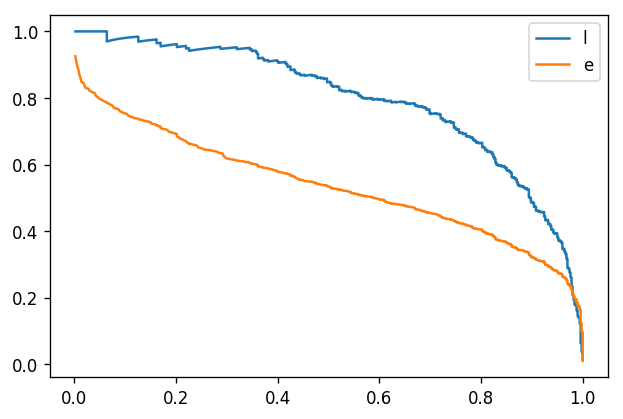

0.672458219504


In [161]:
train_data.reset()
outs = None
labels = None
for i, batch in enumerate(train_data):
    data = batch.data[0].as_in_context(ctx)
    label = batch.label[0].as_in_context(ctx)
    anchors, box_preds, cls_preds = net(data)
    cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode="channel")
    out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
    if outs is None:
        outs = out
        labels = label
    else:
        outs = nd.concat(*[outs, out], dim=0)
        labels = nd.concat(*[labels, label], dim=0)

print outs.shape
print labels.shape
draw_ROC(outs, labels, verbose=True)
print evaluate_MAP(outs, labels, ap_version="11points")

In [5]:

tic = time.time()
for i in range(9):
    a[1:-1, 1:-1, :] - a[:-2, :-2, :]
print time.time() - tic

0.501570940018


## some quetion

In [74]:
import numpy as np
a = np.array([[0, 0, 1, 1]])
b = a + 100
c = a + 0.5
#a = np.sort(a, axis=1)

print b
box = b[:, :]      # refernce, not copy for numpy, use copy()
box[:, 0] = [0.5]  # int type convet
print box
print b
print type(b[0, 0])

[[100 100 101 101]]
[[  0 100 101 101]]
[[  0 100 101 101]]
<type 'numpy.int64'>


In [75]:
b = a[a > 0.5]

In [21]:
print np.sort([1, 3, 4, 2])

[1 2 3 4]
